### Imports

In [1]:
#0
# All Imports

import pandas as pd
import numpy as np
import openai
from openai import OpenAI
import json
import h2o
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from plotnine import ggplot, aes, geom_bar, facet_wrap, theme_light, theme, element_text, ggtitle, labs
from textwrap import wrap
import matplotlib.patches as mpatches
import os
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from pathlib import Path
import re
import warnings
from itertools import count
import keys

openai_api_key = keys.api_key
client = OpenAI(api_key=openai_api_key)

### Extracting Columns

In [2]:
# 1
# This cell loads the original Excel export and keeps only the columns we need
# for the social‑media analysis workflow.



# Silence any SettingWithCopy warnings from pandas if desired
warnings.simplefilter("ignore", pd.errors.SettingWithCopyWarning)

# Path to the raw survey export (adjust if yours lives elsewhere)
DATA_PATH = "data_raw/SurveyQuestionsAndAnswers_28316.xlsx"

# The header row is the 3rd physical row in the sheet → header=2
raw_df = pd.read_excel(DATA_PATH, sheet_name=0, header=2)

# Helper: pick the first column whose name *contains* a given phrase (case‑insensitive)
def pick(col_phrase: str) -> str:
    matches = [c for c in raw_df.columns if col_phrase.lower() in c.lower()]
    if not matches:
        raise ValueError(f"Column containing '{col_phrase}' not found.")
    return matches[0]

# Map concise variable names → actual column names found in the file
col_map = {
    "survey_id"           : pick("Survey ID"),
    "social_channel"      : pick("Which social media channel did you use?"),
    "interest_scale"      : pick("Based on your experience on the Gucci Social Media Channel"),
    "interest_reason_pos" : pick("main reasons why the Gucci Social Media Channel increased"),
    "interest_reason_neg" : pick("main reasons why you did not feel the Gucci Social Media Channel"),
    "scenario"            : pick("What was your scenario?"),
}

# Keep & rename
extracted = raw_df[list(col_map.values())].copy()
extracted.rename(columns={v: k for k, v in col_map.items()}, inplace=True)

# Quick look
extracted.head()

,survey_id,social_channel,interest_scale,interest_reason_pos,interest_reason_neg,scenario
0,3005492,NaN,NaN,NaN,NaN,Booking an Appointment and asking for a certai...
1,3005493,Instagram,I agree,The product display (number of photos and diff...,NaN,Asking for an item seen on social media
2,3005494,Facebook,Neither agree nor disagree,NaN,"The lack of product story telling (origin, ins...",Asking for an item seen on social media
3,3005495,Instagram,I agree,The product display (number of photos and diff...,NaN,Asking for an item seen on social media
4,3005496,NaN,NaN,NaN,NaN,Booking an Appointment and asking for a certai...


### Filtering Dataset to Target Scenerio

In [3]:
# 2
# Keep only surveys where the shopper said their scenario was
# "Asking for an item seen on social media".

SCENARIO_TARGET = "Asking for an item seen on social media"

filtered_df = (
    extracted[
        extracted["scenario"]
        .astype(str)
        .str.strip()
        .str.lower()
        .eq(SCENARIO_TARGET.lower())
    ]
    .copy()
)

print(f"Rows before filter: {len(extracted):,}")
print(f"Rows after  filter: {len(filtered_df):,}")

# Preview the result
filtered_df.head()


Rows before filter: 2,036
Rows after  filter: 1,371


,survey_id,social_channel,interest_scale,interest_reason_pos,interest_reason_neg,scenario
1,3005493,Instagram,I agree,The product display (number of photos and diff...,NaN,Asking for an item seen on social media
2,3005494,Facebook,Neither agree nor disagree,NaN,"The lack of product story telling (origin, ins...",Asking for an item seen on social media
3,3005495,Instagram,I agree,The product display (number of photos and diff...,NaN,Asking for an item seen on social media
5,3005497,Instagram,I strongly agree,The product display (number of photos and diff...,NaN,Asking for an item seen on social media
7,3005499,"Instagram; Other, please specify",I strongly agree,The product display (number of photos and diff...,NaN,Asking for an item seen on social media


### Multi-select Processing

In [4]:
# 3a  ── Multi‑select processing with “Others” / “Others please specify” merged
#
# Builds three sheet types for each target column:
#   • <col>_wide   : full dummy matrix (survey_id + 0/1 flags)
#   • <col>_others : same matrix but <5 % categories collapsed into “Others”
#   • <col>_map    : mapping table (answer_text → wide_col_name + prevalence)
#
# Output file: data_processed/SocMed_processed.xlsx
# ---------------------------------------------------------------------


# Columns to process (already renamed in 'filtered_df')
MULTI_COLS = ["social_channel", "interest_reason_pos", "interest_reason_neg"]

OUTPUT_PATH = Path("data_processed/SocMed_processed.xlsx")
OUTPUT_PATH.parent.mkdir(exist_ok=True)

THRESHOLD = 0.1          # frequency cut‑off for Others
DELIM     = ";"            # delimiter in raw answer strings

def sanitize(text: str) -> str:
    """Return a safe, canonical suffix for a given answer text."""
    text = re.sub(r"\s+", "_", text.strip())
    text = re.sub(r"[^\w]", "", text).lower()

    # ── canonicalise *any* 'other/others ...' variation to 'others'
    if text.startswith(("other", "others")):     # ← add "other" here
        return "others"
    return text


# Choose an engine that’s available
try:
    import xlsxwriter                  # noqa: F401
    engine_name = "xlsxwriter"
except ModuleNotFoundError:
    engine_name = "openpyxl"

with pd.ExcelWriter(OUTPUT_PATH, engine=engine_name) as writer:
    for col in MULTI_COLS:
        # ---------- explode multi‑select answers to get full level list
        exploded = (
            filtered_df[[col]]
            .dropna()
            .assign(**{col: lambda d: d[col].str.split(DELIM)})
            .explode(col)
        )
        raw_levels      = exploded[col].str.strip().unique()
        canon_levels    = [sanitize(lv) for lv in raw_levels]
        unique_cans     = sorted(set(canon_levels))       # “others” appears only once
        wide_cols       = [f"{col}__{c}" for c in unique_cans]

        # ---------- build empty wide dummy frame
        wide = pd.DataFrame(0, index=filtered_df.index, columns=wide_cols)

        # ---------- populate (OR into column to handle merged variants)
        for raw_lv, can_lv in zip(raw_levels, canon_levels):
            col_name = f"{col}__{can_lv}"
            mask = filtered_df[col].fillna("").str.contains(
                rf"\b{re.escape(raw_lv)}\b", case=False, regex=True
            )
            wide[col_name] |= mask.astype(int)

        wide.insert(0, "survey_id", filtered_df["survey_id"].values)
        wide.to_excel(writer, sheet_name=f"{col}_wide", index=False)

        # ---------- build 'Others'‑grouped version
        freqs = wide.drop(columns="survey_id").mean()
        major = freqs[freqs >= THRESHOLD].index.tolist()
        minor = [c for c in wide.columns if c not in major and c != "survey_id"]

        grouped = wide[["survey_id"] + major].copy()
        if minor:
            grouped[f"{col}__others"] = wide[minor].max(axis=1)

        grouped.to_excel(writer, sheet_name=f"{col}_others", index=False)

        # ---------- build mapping table
        map_df = (
            pd.DataFrame({
                "original_column": col,
                "answer_text"    : raw_levels,
                "wide_col_name"  : [f"{col}__{c}" for c in canon_levels],
                "prevalence"     : [freqs[f"{col}__{c}"] for c in canon_levels],
            })
            .sort_values("prevalence", ascending=False)
        )

        sheet_alias = {
            "social_channel":      "social_channel_map",
            "interest_reason_pos": "int_pos_map",
            "interest_reason_neg": "int_neg_map",
        }[col]

        map_df.to_excel(writer, sheet_name=sheet_alias, index=False)

        print(
            f"{col}: {len(raw_levels)} raw options → "
            f"{len(unique_cans)} canonical, {len(major)} kept, "
            f"{len(minor)} in 'Others'"
        )

print(f"\n✔️  Sheets written to {OUTPUT_PATH} (engine: {engine_name}).")

social_channel: 8 raw options → 8 canonical, 3 kept, 5 in 'Others'
interest_reason_pos: 8 raw options → 8 canonical, 3 kept, 5 in 'Others'
interest_reason_neg: 8 raw options → 8 canonical, 1 kept, 7 in 'Others'

✔️  Sheets written to data_processed\SocMed_processed.xlsx (engine: openpyxl).


In [5]:
# 3b
# This cell APPENDS new sheets with a simple (question_id, answer_id)
# scheme so every wide_col_name has an unambiguous code pair.



MULTI_COLS   = [
    ("social_channel",      col_map["social_channel"]),
    ("interest_reason_pos", col_map["interest_reason_pos"]),
    ("interest_reason_neg", col_map["interest_reason_neg"]),
]
OUTPUT_PATH  = "data_processed/SocMed_processed.xlsx"   # append
THRESHOLD    = 0.1
DELIM        = ";"

# Re‑open the existing workbook in append mode
with pd.ExcelWriter(OUTPUT_PATH, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    for short_name, raw_colname in MULTI_COLS:
        # 1️⃣ collect answer levels again (order preserved)
        exploded = (
            filtered_df[[short_name]]
            .dropna()
            .assign(**{short_name: lambda d: d[short_name].str.split(DELIM)})
            .explode(short_name)
        )
        levels = exploded[short_name].str.strip().unique()

        # 2️⃣ pull prevalence from previous wide sheet
        prev_wide = pd.read_excel(OUTPUT_PATH, sheet_name=f"{short_name}_wide")
        freqs = prev_wide.drop(columns="survey_id").mean()

        # 3️⃣ build synthetic IDs
        ans_id_iter = count(1)
        map_df = pd.DataFrame({
            "question_id"     : raw_colname,                                   # visible header text
            "answer_id"       : [next(ans_id_iter) for _ in levels],
            "answer_text"     : levels,
            "wide_col_name"   : [f"{short_name}__{sanitize(lv)}" for lv in levels],
            "prevalence"      : [freqs[f"{short_name}__{sanitize(lv)}"] for lv in levels],
        })

        # 4️⃣ write to workbook with compact sheet names (<=31 chars)
        sheet_name = {
            "social_channel"     : "social_chan_idmap",
            "interest_reason_pos": "int_pos_idmap",
            "interest_reason_neg": "int_neg_idmap",
        }[short_name]

        map_df.to_excel(writer, sheet_name=sheet_name, index=False)
        print(f"Added sheet '{sheet_name}' with {len(levels)} rows.")

print("\n✔️  Synthetic ID mapping sheets appended to the existing workbook.")

Added sheet 'social_chan_idmap' with 8 rows.
Added sheet 'int_pos_idmap' with 8 rows.
Added sheet 'int_neg_idmap' with 8 rows.

✔️  Synthetic ID mapping sheets appended to the existing workbook.


In [6]:
#3c
# Sheet produced:  column_value_map  (replaces any existing one)
# Columns: wide_col_name • question_id • answer_id • answer_text
#          prevalence • column names and value combination sum



WB_PATH = Path("data_processed/SocMed_processed.xlsx")

# --- A) gather rows from the three *_idmap sheets ---------------------
IDMAP_SHEETS = ["social_chan_idmap", "int_pos_idmap", "int_neg_idmap"]

rows = []
for sh in IDMAP_SHEETS:
    df = pd.read_excel(WB_PATH, sheet_name=sh)
    rows.append(df[["wide_col_name", "question_id", "answer_id",
                    "answer_text", "prevalence"]])

column_value_map = pd.concat(rows, ignore_index=True).sort_values("wide_col_name")

# --- B) compute absolute counts from each *_wide matrix --------------
WIDE_SHEETS = {
    "social_channel_wide",
    "interest_reason_pos_wide",
    "interest_reason_neg_wide",
}

counts = {}
for sh in WIDE_SHEETS:
    wide = pd.read_excel(WB_PATH, sheet_name=sh)
    for col in wide.columns:
        if col != "survey_id":
            counts[col] = int(wide[col].sum())

# align counts to the master map
count_series = pd.Series(counts, name="column names and value combination sum")
column_value_map = column_value_map.merge(
    count_series,
    how="left",
    left_on="wide_col_name",
    right_index=True
)

# --- C) write / replace the sheet ------------------------------------
with pd.ExcelWriter(WB_PATH, engine="openpyxl",
                    mode="a", if_sheet_exists="replace") as writer:
    column_value_map.to_excel(writer, sheet_name="column_value_map", index=False)

print(f"✔️  column_value_map updated with {len(column_value_map)} rows "
      f"and count column added.")

✔️  column_value_map updated with 24 rows and count column added.


### Likert Scale Processing

In [7]:
# ---- 4A (revised): ADD NUMERIC & SCALED LIKERT COLUMNS --------------
# Creates two new columns inside filtered_df:
#   • interest_scale_num     (1‒5)
#   • interest_scale_scaled  (0‒1)



# text → numeric mapping
likert_map = {
    "i strongly disagree": 1,
    "i disagree": 2,
    "neither agree nor disagree": 3,
    "i agree": 4,
    "i strongly agree": 5,
}

def to_numeric(txt):
    if pd.isna(txt):
        return np.nan
    return likert_map.get(str(txt).strip().lower(), np.nan)

filtered_df["interest_scale_num"] = filtered_df["interest_scale"].apply(to_numeric)
filtered_df["interest_scale_scaled"] = (filtered_df["interest_scale_num"] - 1) / 4

print("✔️  Columns 'interest_scale_num' and 'interest_scale_scaled' "
      "added to filtered_df.")

✔️  Columns 'interest_scale_num' and 'interest_scale_scaled' added to filtered_df.


In [8]:
# 4b
# EXPORT LIKERT DATA & SUMMARY TO EXCEL 
# Creates / replaces two sheets in the workbook:
#   1) interest_scale_data    – row‑level data with the 3 columns
#   2) interest_scale_summary – already built, but overwrite to ensure sync
#
# Sheet 1 columns (order matters):
#   survey_id • interest_scale • interest_scale_num • interest_scale_scaled
#
# Sheet 2 columns:
#   likert_text • count • numeric_value • scaled_value



WB_PATH = Path("data_processed/SocMed_processed.xlsx")

# --- build row‑level table -------------------------------------------
likert_data = filtered_df[[
    "survey_id",
    "interest_scale",
    "interest_scale_num",
    "interest_scale_scaled"
]]

# --- build summary table (re‑compute to stay in sync) -----------------
summary = (
    filtered_df["interest_scale"]
    .value_counts(dropna=False)
    .rename_axis("likert_text")
    .reset_index(name="count")
)

def to_numeric(txt):
    mapping = {
        "i strongly disagree": 1,
        "i disagree": 2,
        "neither agree nor disagree": 3,
        "i agree": 4,
        "i strongly agree": 5,
    }
    return mapping.get(str(txt).strip().lower(), pd.NA)

summary["numeric_value"] = summary["likert_text"].apply(to_numeric)
summary["scaled_value"] = (summary["numeric_value"] - 1) / 4

# --- write / overwrite both sheets -----------------------------------
with pd.ExcelWriter(WB_PATH, engine="openpyxl",
                    mode="a", if_sheet_exists="replace") as writer:
    likert_data.to_excel(writer, sheet_name="interest_scale_data", index=False)
    summary.to_excel(writer,     sheet_name="interest_scale_summary", index=False)

print("✔️  Sheets 'interest_scale_data' (row‑level) and "
      "'interest_scale_summary' (aggregated) written to workbook.")

✔️  Sheets 'interest_scale_data' (row‑level) and 'interest_scale_summary' (aggregated) written to workbook.


### Combine to One Sheet

In [9]:
# 5
# Build a one‑sheet workbook that merges the three “filtered others” blocks
# + the scaled‑Likert column (aligned on survey_id)
# + flags for multiple responses in first three questions
# ------------------------------------------------------------------

SOURCE_PATH = Path("data_processed/SocMed_processed.xlsx")
DEST_PATH   = Path("data_processed/Combined_SocMed_processed.xlsx")   # overwrites if exists

# ── Load the required sheets --------------------------------------------------
with pd.ExcelFile(SOURCE_PATH) as xls:
    sc_others  = pd.read_excel(xls, "social_channel_others")
    pos_others = pd.read_excel(xls, "interest_reason_pos_others")
    neg_others = pd.read_excel(xls, "interest_reason_neg_others")

    # Keep only the scaled metric (and survey_id for merging)
    scale_data = pd.read_excel(
        xls,
        "interest_scale_data",
        usecols=["survey_id", "interest_scale_scaled"]
    )

# ── Merge everything on survey_id (inner join keeps rows present in all) -----
combined = (
    sc_others
      .merge(pos_others, on="survey_id", how="inner")
      .merge(neg_others, on="survey_id", how="inner")
      .merge(scale_data, on="survey_id", how="inner")
)

# ── Build new multi‑response columns -----------------------------------------
social_cols = [c for c in combined if c.startswith("social_channel__")]
pos_cols    = [c for c in combined if c.startswith("interest_reason_pos__")]
neg_cols    = [c for c in combined if c.startswith("interest_reason_neg__")]

combined["social_channel__multi"] = (combined[social_cols].sum(axis=1) > 1).astype(int)
combined["interest_reason_pos__multi"] = (combined[pos_cols].sum(axis=1) > 1).astype(int)
combined["interest_reason_neg__multi"] = (combined[neg_cols].sum(axis=1) > 1).astype(int)

# ── Reorder columns so new flags follow their respective groups ---------------
new_order = ["survey_id"]

# Insert social_channel group + flag
new_order += social_cols + ["social_channel__multi"]

# Insert interest_reason_pos group + flag
new_order += pos_cols + ["interest_reason_pos__multi"]

# Insert interest_reason_neg group + flag
new_order += neg_cols + ["interest_reason_neg__multi"]

# Add any remaining columns (like interest_scale_scaled) at the end
remaining = [c for c in combined.columns if c not in new_order]
new_order += remaining

combined = combined[new_order]

# ── Write the single‑sheet workbook ------------------------------------------
try:
    import xlsxwriter                # noqa: F401
    engine_name = "xlsxwriter"
except ModuleNotFoundError:
    engine_name = "openpyxl"

with pd.ExcelWriter(DEST_PATH, engine=engine_name, mode="w") as writer:
    combined.to_excel(writer, sheet_name="combined", index=False)

print(
    f"✔️  {combined.shape[0]:,} rows × {combined.shape[1]} columns "
    f"written to {DEST_PATH.resolve()}"
)
print("New columns inserted after their groups.")
print("Preview:\n", combined.iloc[:5, :15])  # show first 15 cols for context


✔️  1,371 rows × 14 columns written to C:\Azure-dev-ops-repos\RM-Data-Science-Workbench\Insights-First-Attempt\data_processed\Combined_SocMed_processed.xlsx
New columns inserted after their groups.
Preview:
    survey_id  social_channel__facebook  social_channel__instagram  \
0    3005493                         0                          1   
1    3005494                         1                          0   
2    3005495                         0                          1   
3    3005497                         0                          1   
4    3005499                         0                          1   

   social_channel__others  social_channel__multi  \
0                       0                      0   
1                       0                      0   
2                       0                      0   
3                       0                      0   
4                       0                      0   

   interest_reason_pos__the_gucci_social_media_channel_provided_

### Create PCA

In [10]:
#6a 
# load the data, load the columns inidividually

# 1) Load the workbook / sheet
file_path   = "data_processed/Combined_SocMed_processed.xlsx"
df_combined = pd.read_excel(file_path, sheet_name="combined")

# 2) Separate identifier
survey_ids  = df_combined["survey_id"]
df_prepared = df_combined.drop(columns=["survey_id"])

# 3) EXPLICIT column list (15 + 3 multi-response flags in your file)
cols_for_pca = [
    # ── social‑channel dummies
    'social_channel__facebook',
    'social_channel__instagram',
    #'social_channel__kakaotalk',
    'social_channel__others',
    #'social_channel__redbook',
    #'social_channel__wechat',

    # ── social‑channel multi flag
    'social_channel__multi',

    # ── positive‑reason dummies
    'interest_reason_pos__the_gucci_social_media_channel_provided_the_right_amount_of_relevant_information',
    'interest_reason_pos__the_product_availability_information',
    'interest_reason_pos__the_product_description',
    'interest_reason_pos__others',

    # ── positive‑reason multi flag
    'interest_reason_pos__multi',

    # ── negative‑reason dummies
    'interest_reason_neg__the_gucci_social_media_channel_did_not_provide_the_right_amount_of_relevant_information',
    #'interest_reason_neg__the_lack_of_clarity_on_product_availability_or_the_product_was_not_available_at_all',
    #'interest_reason_neg__the_product_description',
    'interest_reason_neg__others',

    # ── negative‑reason multi flag
    'interest_reason_neg__multi',

    # ── scaled Likert metric
    'interest_scale_scaled'
]

# 4) Build the DataFrame that will feed scaling / PCA
df_prepared_section_scores_only = df_prepared[cols_for_pca].copy()

# 5) Quick sanity check
print("Columns selected for PCA:", len(cols_for_pca))
for c in cols_for_pca:
    print("  •", c)

print("\nShape of df_prepared_section_scores_only:", df_prepared_section_scores_only.shape)
df_prepared_section_scores_only.head()


Columns selected for PCA: 13
  • social_channel__facebook
  • social_channel__instagram
  • social_channel__others
  • social_channel__multi
  • interest_reason_pos__the_gucci_social_media_channel_provided_the_right_amount_of_relevant_information
  • interest_reason_pos__the_product_availability_information
  • interest_reason_pos__the_product_description
  • interest_reason_pos__others
  • interest_reason_pos__multi
  • interest_reason_neg__the_gucci_social_media_channel_did_not_provide_the_right_amount_of_relevant_information
  • interest_reason_neg__others
  • interest_reason_neg__multi
  • interest_scale_scaled

Shape of df_prepared_section_scores_only: (1371, 13)


,social_channel__facebook,social_channel__instagram,social_channel__others,social_channel__multi,interest_reason_pos__the_gucci_social_media_channel_provided_the_right_amount_of_relevant_information,interest_reason_pos__the_product_availability_information,interest_reason_pos__the_product_description,interest_reason_pos__others,interest_reason_pos__multi,interest_reason_neg__the_gucci_social_media_channel_did_not_provide_the_right_amount_of_relevant_information,interest_reason_neg__others,interest_reason_neg__multi,interest_scale_scaled
0,0,1,0,0,1,0,0,0,0,0,0,0,0.75
1,1,0,0,0,0,0,0,0,0,0,0,0,0.50
2,0,1,0,0,0,0,1,0,0,0,0,0,0.75
3,0,1,0,0,1,0,0,0,0,0,0,0,1.00
4,0,1,0,0,0,0,1,0,0,0,0,0,1.00


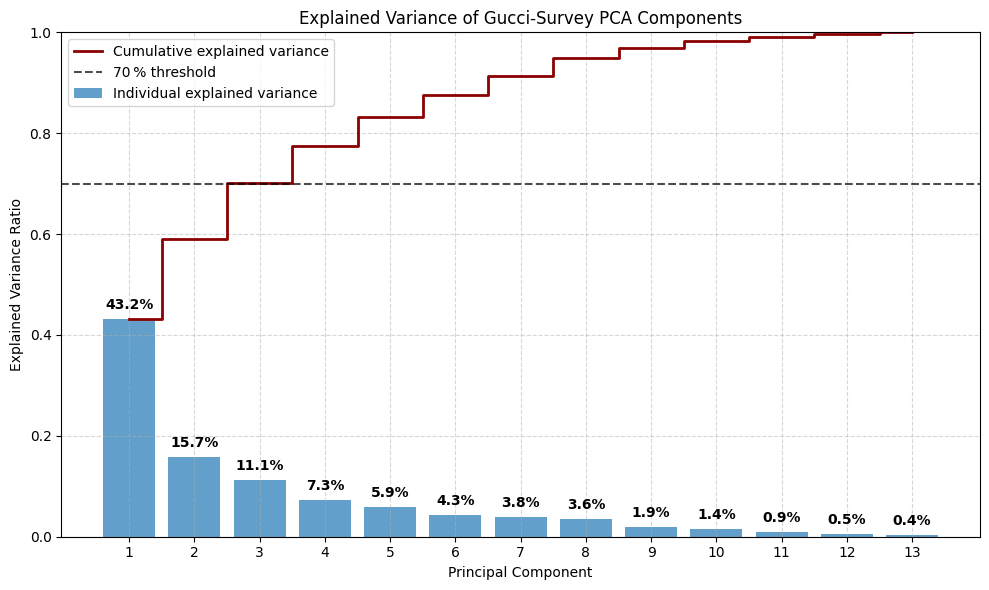

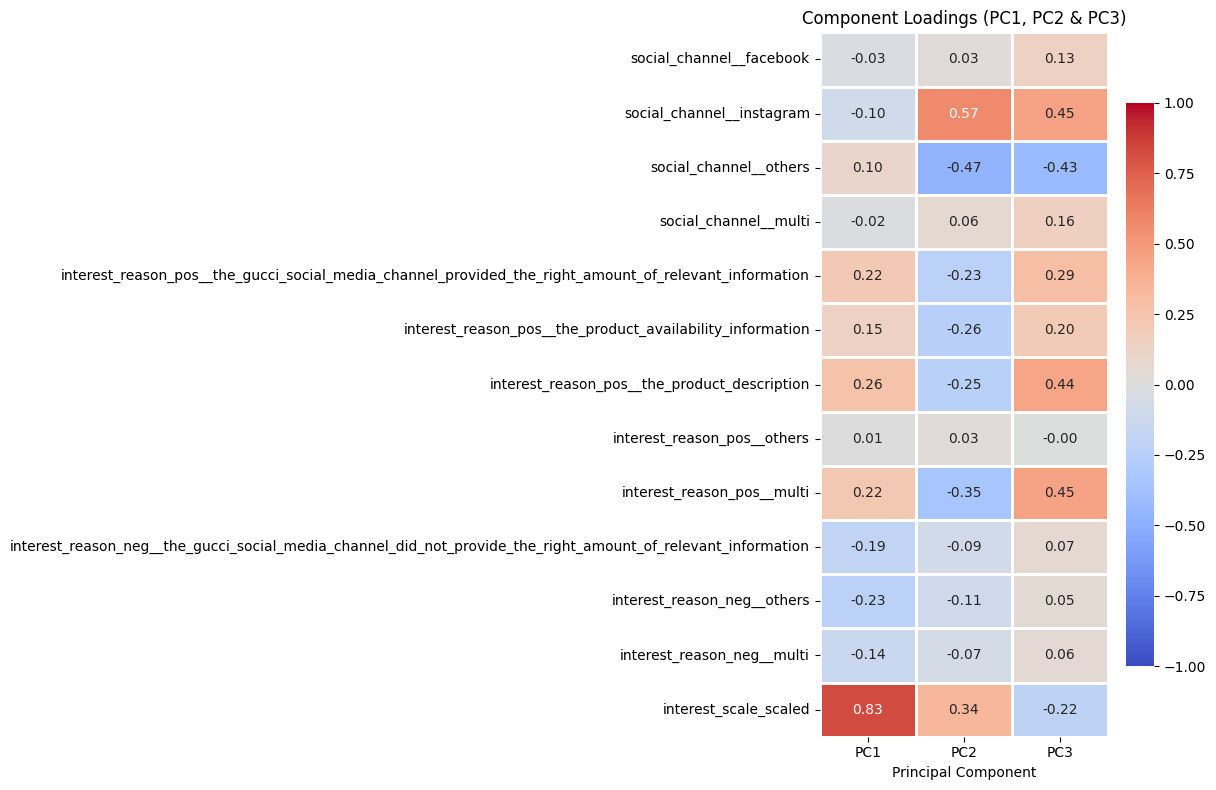

In [11]:
# 6b
#  Robust‑PCA workflow on the 18 Gucci‑survey predictors ────────────

OUT_DIR = "Full_PCA_Output"
os.makedirs(OUT_DIR, exist_ok=True)

# 1) Prepare the data
predictor_columns = df_prepared_section_scores_only.columns.tolist()
X_raw             = df_prepared_section_scores_only[predictor_columns]

# 2) Robust scaling
robust_scaler = RobustScaler()
X_scaled      = robust_scaler.fit_transform(X_raw)

# 3) PCA (all components retained)
pca                 = PCA()
pca_scores          = pca.fit_transform(X_scaled)
explained_variance  = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# 4) Explained‑variance chart (unchanged)
plt.figure(figsize=(10, 6))
plt.bar(
    np.arange(1, len(explained_variance) + 1),
    explained_variance,
    alpha=0.7,
    label='Individual explained variance',
)
plt.step(
    np.arange(1, len(cumulative_variance) + 1),
    cumulative_variance,
    where='mid',
    color='darkred',
    linewidth=2,
    label='Cumulative explained variance'
)
plt.axhline(y=0.70, linestyle='--', color='k', alpha=0.7, label='70 % threshold')
for i, v in enumerate(explained_variance):
    plt.text(i + 1, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')
plt.xlabel('Principal Component'); plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance of Gucci‑Survey PCA Components')
plt.xticks(np.arange(1, len(explained_variance) + 1)); plt.ylim(0, 1.0)
plt.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.tight_layout()
plt.savefig(f"{OUT_DIR}/gucci_pca_explained_variance.png", dpi=300)
plt.show()

# 5) Component‑loading heatmap — now for PC1, PC2, PC3
loading_matrix = pca.components_.T                      # shape: (18, n_components)
pc_labels      = ['PC1', 'PC2', 'PC3']                  # first three PCs
loading_df     = pd.DataFrame(
    loading_matrix[:, :3],                              # keep three columns
    index=predictor_columns,
    columns=pc_labels
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    loading_df,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.8,
    cbar_kws={"shrink": .8}
)
plt.title('Component Loadings (PC1, PC2 & PC3)')
plt.xlabel('Principal Component'); plt.ylabel('')
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/gucci_pca_component_loadings_PC1_PC2_PC3.png", dpi=300)
plt.show()


### Interpret PCA Results

In [12]:
# 7a
# PCA Setup & JSON Packaging 

# Ensure output directory exists
os.makedirs("Output Data", exist_ok=True)

# Load combined sheet
file_path = "data_processed/Combined_SocMed_processed.xlsx"
df_combined = pd.read_excel(file_path, sheet_name="combined")

# Exclude non-numeric ID column
audit_data = df_combined.drop(columns=["survey_id"])

# Explicitly ensure multi-response flags are included
multi_cols = [c for c in df_combined.columns if c.endswith("__multi")]
audit_data = audit_data[[c for c in audit_data.columns]]  # keeps order including multi cols

# 1) Robust scale (median & IQR)
scaler = RobustScaler()
scaled_data = scaler.fit_transform(audit_data)

# 2) PCA on scaled data
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# 3) Variance DataFrame
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

df_variance = pd.DataFrame({
    "Explained Variance": explained_var,
    "Cumulative Explained Var": cum_var
}, index=[f"PC{i+1}" for i in range(len(explained_var))])

# 4) Loadings DataFrame
df_loadings = pd.DataFrame(
    pca.components_.T,
    index=audit_data.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Sort features by |PC1| for readability
df_loadings_sorted = df_loadings.loc[
    df_loadings["PC1"].abs().sort_values(ascending=False).index
]

# 5) Convert to JSON
variance_json = json.dumps(df_variance.to_dict(), indent=2)
loadings_json = json.dumps(df_loadings_sorted.to_dict(orient="index"), indent=2)

print("Prepared PCA JSON payloads.")
print("• Variance JSON length:", len(variance_json))
print("• Loadings JSON length:", len(loadings_json))
print("Included columns:", list(audit_data.columns))


Prepared PCA JSON payloads.
• Variance JSON length: 899
• Loadings JSON length: 6248
Included columns: ['social_channel__facebook', 'social_channel__instagram', 'social_channel__others', 'social_channel__multi', 'interest_reason_pos__the_gucci_social_media_channel_provided_the_right_amount_of_relevant_information', 'interest_reason_pos__the_product_availability_information', 'interest_reason_pos__the_product_description', 'interest_reason_pos__others', 'interest_reason_pos__multi', 'interest_reason_neg__the_gucci_social_media_channel_did_not_provide_the_right_amount_of_relevant_information', 'interest_reason_neg__others', 'interest_reason_neg__multi', 'interest_scale_scaled']


In [13]:
# # 7b
# # OpenAI PCA Interpretation (PC1 & PC2 only) 

# # Filter JSON to PC1 & PC2
# df_variance_2 = df_variance.iloc[:2]
# df_loadings_2 = df_loadings[["PC1", "PC2"]]

# variance_json = json.dumps(df_variance_2.to_dict(), indent=2)
# loadings_json = json.dumps(df_loadings_2.to_dict(orient="index"), indent=2)

# prompt_text = f"""
# We have PCA results from Gucci's social-media survey data.

# ### PCA Loadings (PC1 & PC2 only) ###
# {loadings_json}

# ### Explained Variance (PC1 & PC2 only) ###
# {variance_json}

# **Your tasks:**
# 1. Provide an executive summary explaining what PCA is and why we use it here.
# 2. Describe in plain language what PC1 and PC2 represent.
#    - Assign interpretable names.
#    - Use only PC1 and PC2.
# 3. Suggest names for the 4 shop segments formed by the quadrants of PC1 vs PC2.
# 4. Highlight surprising findings (limited to PC1 and PC2).
# 5. Provide 1–2 actionable recommendations for Gucci’s distributor.
# 6. Comment on whether PC1 & PC2 coverage is satisfactory.

# Format output in markdown.
# """

# response = client.responses.create(
#     model="o3",
#     reasoning={"effort": "high"},
#     input=[{"role": "user", "content": prompt_text}]
# )

# interpretation = response.output_text

# with open("Output Data/gucci_pca_PC1_PC2.md", "w", encoding="utf-8") as f:
#     f.write(interpretation)

# print("✔️ Saved: Output Data/gucci_pca_PC1_PC2.md")
# print("Included features in loadings:", list(df_loadings_2.index))


In [ ]:
# 7c – OpenAI PCA Interpretation (PC1–PC3)  ──────────────────────────────────
import json, textwrap
from pathlib import Path
from openai import OpenAI
from IPython.display import Markdown, display

# ---------------------------------------------------------------------------
# Build df_variance / df_loadings if they’re not already in memory
# ---------------------------------------------------------------------------
if "df_variance" not in globals() or "df_loadings" not in globals():
    out_dir = Path("Task1_Exp1_output")
    df_variance = pd.read_json(out_dir / "likert_pca_variance.json")
    df_loadings = pd.read_json(out_dir / "likert_pca_loadings.json")

df_variance_3 = df_variance.iloc[:3]
df_loadings_3 = df_loadings[["PC1", "PC2", "PC3"]]

variance_json = json.dumps(df_variance_3.to_dict(), indent=2)
loadings_json = json.dumps(df_loadings_3.to_dict(orient="index"), indent=2)

# ---------------------------------------------------------------------------
# Your unedited prompt text
# ---------------------------------------------------------------------------
prompt_text = f"""
We have PCA results from Gucci's social-media survey data. 

### High Level Context ###
summary of the projecT: The mystery shopping survey template is designed to comprehensively evaluate a customer’s experience across multiple touchpoints with a luxury brand (e.g., Gucci), including website navigation, social media engagement, appointment booking, in-store service, digital content interaction, product availability scenarios, omnichannel consistency, and post-visit follow-up. The objective of the mystery shop is to assess the performance of client advisors and overall brand experience from a customer-centric perspective, focusing on interpersonal skills, product knowledge, proactivity, and the ability to build connection and inspire purchase decisions — while ensuring alignment with brand values and service standards. The survey emphasizes feedback on the Advisor’s behavior, communication, and service delivery, while excluding judgments about store location, pricing, or products themselves. Ultimately, the goal is to identify strengths and areas for improvement in the customer journey to enhance client retention, brand loyalty, and service excellence.

### High Level Description of the Orignal Data ###
Your task is to interpret results from PCA analysis. The survey has many questions, right now our analysis is focused only on the following questions below. Listed with them is their answers. Please not that "Other, please specify" represents an answer choice, which others, represenets a seperate category of answers that contains all answer choices with <5% selected. Each unique answer will be in quotations so that you don't get confused. Also worth mentioning we are only using the scenerio: "Asking for an item seen on social media".
ID: 406171, Question: Which social media channel did you use?
Possible Answers: "Instagram", "Facebook", "WeChat", "KakaoTalk", "Other, please specify", "Redbook", "Other"

ID: 383199, Question: Based on your experience on the Gucci Social Media Channel, to which extend would you say:“I felt this experience increased my interest for the products”
Possible Answers (The only likert question): "I strongly Agree"," I agree", "Neither agree nor disagree", "I disagree", "I strongly disagree"

ID: 382430, Question: Please select the main reasons why the Gucci Social Media Channel increased your interest for the products
Possible Answers: "The product display (number of photos and different angles, with product worn by mannequin, zoom available)", "The product description", "The product story telling (origin, inspiration, sustainability, legacy of the product)", "The ways of visualizing the products (tutorials, virtual try-on, 3D visual, etc.)", "The product availability information", "The product price (readily available)", "The Gucci Social Media Channel provided the right amount of relevant information", "Other"

ID: 394261, Question: Please select the main reasons why you did not feel the Gucci Social Media Channel increased your interest in the products
Possible Answers
"The product display (number of photos and different angles, with product worn by mannequin, zoom available)", "The product description", "The lack of clarity on product availability, or the product was not available at all", "The product price (not easy to find)", "The Gucci Social Media Channel did not provide the right amount of relevant information", "other"

### PCA Loadings (PC1–PC3) ###
{loadings_json}

### Explained Variance (PC1–PC3) ###
{variance_json}

**Your tasks:**
1. Provide an executive summary explaining what PCA is and why we use it here.
2. Describe in plain language what PC1, PC2, and PC3 represent.
   - Assign interpretable names.
3. Suggest names for 4 shop segments (PC1 vs PC2).
4. Highlight surprising findings, considering PCs 1–3.
5. Provide 1–2 actionable recommendations for Gucci’s distributor.
6. Comment on whether PC1–PC3 coverage is satisfactory.

Format output in markdown.
"""

# ---------------------------------------------------------------------------
# Call OpenAI (model o3, no temperature override)
# ---------------------------------------------------------------------------
client = OpenAI(api_key=keys.api_key)

resp = client.chat.completions.create(
    model="o3",
    messages=[{"role": "user", "content": prompt_text}]
)

interpretation_md = resp.choices[0].message.content.strip()

# ---------------------------------------------------------------------------
# Save & preview
# ---------------------------------------------------------------------------
Path("Output Data").mkdir(exist_ok=True)
out_path = Path("Output Data/gucci_pca_PC1_PC2_PC3.md")
out_path.write_text(interpretation_md, encoding="utf-8")

print("✔️ Saved:", out_path)



✔️ Saved: Output Data\gucci_pca_PC1_PC2_PC3.md


### Graphs

✔️  2-D plot saved to Output Data\4question_pca_2D_quadrants.png


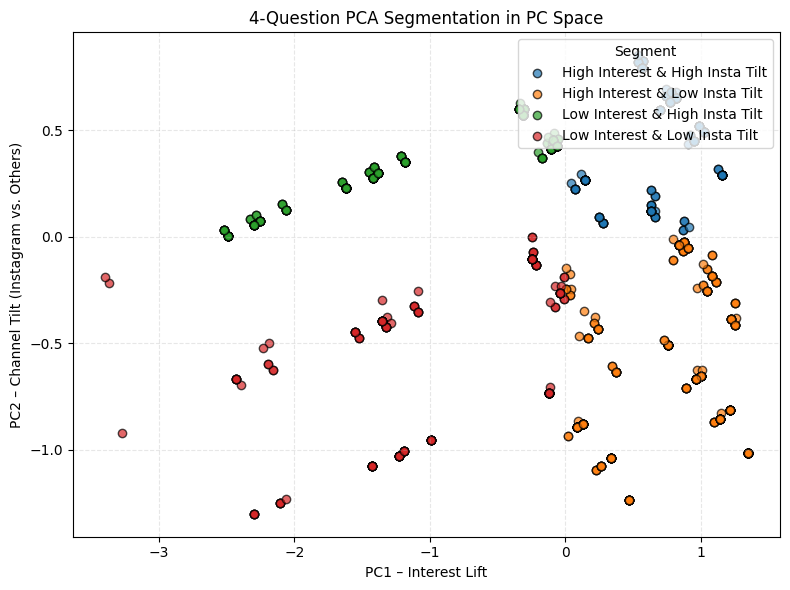

In [59]:
# Cell X – 2-D scatter of 4-Question PCA segments (quadrants of PC1 × PC2)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# — assume you already have `scores4` (n_samples × 4) and your original df_block —
pcs4_df = pd.DataFrame(
    scores4[:, :2],
    columns=["PC1", "PC2"],
    index=df_block.index
)

# 1. Define quadrants → labels
conditions = [
    (pcs4_df["PC1"] >= 0) & (pcs4_df["PC2"] >= 0),  # Q1: High PC1 & High PC2
    (pcs4_df["PC1"] >= 0) & (pcs4_df["PC2"] <  0),  # Q2: High PC1 & Low  PC2
    (pcs4_df["PC1"] <  0) & (pcs4_df["PC2"] >= 0),  # Q3: Low  PC1 & High PC2
    (pcs4_df["PC1"] <  0) & (pcs4_df["PC2"] <  0),  # Q4: Low  PC1 & Low  PC2
]
labels = [
    "High Interest & High Insta Tilt",   # inspired by Q1
    "High Interest & Low Insta Tilt",    # inspired by Q2
    "Low Interest & High Insta Tilt",    # inspired by Q3
    "Low Interest & Low Insta Tilt",     # inspired by Q4
]
# string default to keep dtype object
pcs4_df["segment"] = np.select(conditions, labels, default="")

# 2. Define a color for each segment
palette = {
    "High Interest & High Insta Tilt":   "#1f77b4",
    "High Interest & Low Insta Tilt":    "#ff7f0e",
    "Low Interest & High Insta Tilt":    "#2ca02c",
    "Low Interest & Low Insta Tilt":     "#d62728",
}

# 3. Plot
fig, ax = plt.subplots(figsize=(8,6))
for seg, color in palette.items():
    sub = pcs4_df[pcs4_df["segment"] == seg]
    ax.scatter(
        sub["PC1"], sub["PC2"],
        label=seg,
        color=color,
        alpha=0.7,
        edgecolor="k"
    )

# 4. Polish axes, title, legend
ax.set_xlabel("PC1 \u2013 Interest Lift")
ax.set_ylabel("PC2 \u2013 Channel Tilt (Instagram vs. Others)")
ax.set_title("4-Question PCA Segmentation in PC Space")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(title="Segment", loc="upper right")

plt.tight_layout()

# 5. Save
out_dir = "Output Data"
os.makedirs(out_dir, exist_ok=True)
save_path = os.path.join(out_dir, "4question_pca_2D_quadrants.png")
plt.savefig(save_path, dpi=300)
print(f"✔️  2-D plot saved to {save_path}")
plt.show()


C:\Users\vicra\AppData\Local\Temp\ipykernel_5060\3887176530.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


✔️  3-D plot saved to Output Data\4question_pca_3D_clusters.png


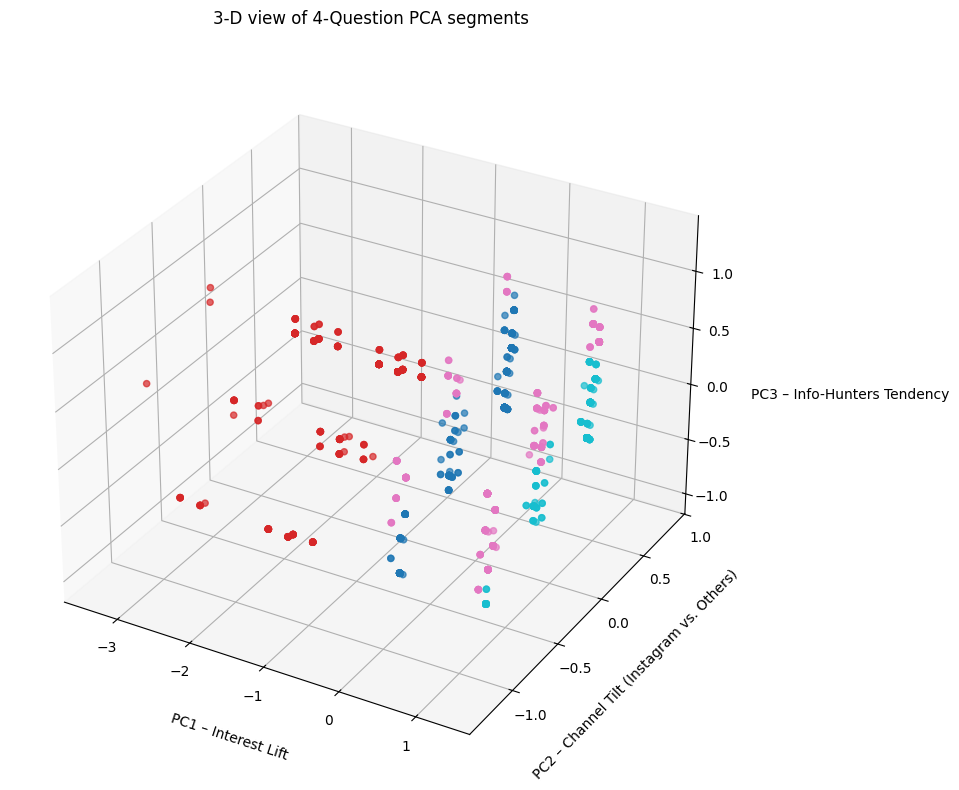

In [57]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pathlib import Path
from sklearn.cluster import KMeans

# --- assume scores4 already exists ---
kmeans4 = KMeans(n_clusters=4, random_state=42).fit(scores4[:, :3])
labels4 = kmeans4.labels_
cmap    = cm.get_cmap("tab10", 4)
colors  = [cmap(l) for l in labels4]

# 1) Figure + 3D Axes
fig = plt.figure(figsize=(12, 8), facecolor="white", constrained_layout=False)
ax  = fig.add_subplot(111, projection="3d", facecolor="white")

# 2) Scatter
ax.scatter(
    scores4[:, 0], scores4[:, 1], scores4[:, 2],
    c=colors, alpha=0.7, s=20
)

# 3) X/Y labels
ax.set_xlabel("PC1 – Interest Lift",                       labelpad=15)
ax.set_ylabel("PC2 – Channel Tilt (Instagram vs. Others)", labelpad=15)

# 4) Main title
ax.set_title("3-D view of 4-Question PCA segments", pad=25)

# 5) Pull the PC3 descriptor out of the axis and up into a subtitle
#    Adjust 'y' until it sits nicely under your main title
fig.text(
    0.9,      # horizontal center
    0.5,     # vertical position in figure coords (0=bot,1=top)
    "PC3 – Info-Hunters Tendency",
    ha="center", va="center",
    fontsize=10
)

# 6) Tidy up margins
plt.subplots_adjust(left=0.15, right=0.95, top=0.88, bottom=0.10)
plt.tight_layout()

# 7) Save & show
out_dir = Path("Output Data"); out_dir.mkdir(exist_ok=True)
save_path = out_dir / "4question_pca_3D_clusters.png"
plt.savefig(save_path, dpi=300, facecolor=fig.get_facecolor(), bbox_inches="tight")
print(f"✔️  3-D plot saved to {save_path}")

plt.show()
